## Variable wedge

Building on spectral wedge... I would like a wedge that varies rock properties in the *y*-dimension.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline

Set up the model parameters.

In [3]:
length = 100.# x range
width = 100. # y range
depth = 240. # z range

Use the wedge code from <code>Spectral_wedge.ipynb</code>. The main difference is that we will need to use the rock properties directly, rather than building an array of <code>int</code>s first. 

In [4]:
rocks = [(2800, 2850), (2800, 2850), (2400, 2450), (2400,2450)]

def make_ai(rocks):
    rx = np.array(rocks)
    return rx[:,0] * rx[:,1] / 10e6

ai = make_ai(rocks)
print ai

[ 0.798  0.798  0.588  0.588]


In [5]:
def make_earth(depth, length, width, ai):
    
    earth = np.ones((depth,length,width))
    
    for xslice in range(int(length)):
        thickness = (depth/3)*(1 + xslice/length)
        mix = (ai[1]*xslice/length) + (ai[2]*(length-xslice)/length)
        
        # Draw wedge
        earth[:,xslice,:] *= mix    

        earth[thickness:,xslice,:] = ai[0]

    # Put the top on
    earth[:depth/3,:,:] = ai[3]
 
    return earth

In [8]:
earth = make_earth(depth, length, width, ai)

Now we have a 3D model. We'd like to look at it. Without getting into Mayavi, the easiest thing to do is to just look at some x, y, and z slices. Let's make a function to do this, since we'll want it again for the synthetic. 

In [9]:
def plot_slices(data, interpolation='nearest', cmap='Greys', vmin=0., vmax=1.):
    plt.figure(figsize=(16,12))
    
    for j in range(3):
        plt.subplot(3,4,j+1)
        plt.title('y = ' + str(int(j*(length/3))))
        plt.imshow(data[:,:,int(j*(length/3))], interpolation=interpolation, cmap=cmap, vmax=vmax, vmin=vmin)
    plt.subplot(3,4,4)
    plt.title('y = ' + str(int(length-1)))
    plt.imshow(data[:,:,-1], interpolation=interpolation, cmap=cmap, vmax=vmax, vmin=vmin)
    
    for j in range(3):
        plt.subplot(3,4,5+j)
        plt.title('x = ' + str(int(j*(width/3))))
        plt.imshow(data[:,int(j*(width/3)),:], interpolation=interpolation, cmap=cmap, vmax=vmax, vmin=vmin)
    plt.subplot(3,4,8)
    plt.title('x = ' + str(int(width-1)))
    plt.imshow(data[:,-1,:], interpolation=interpolation, cmap=cmap, vmax=vmax, vmin=vmin)
    
    for j in range(3):
        plt.subplot(3,4,9+j)
        plt.title('z = ' + str(1 + int(1 + depth/3 + j*depth/(3*3))))
        plt.imshow(data[1 + int(depth/3 + j*depth/(3*3)),:,:], interpolation=interpolation, cmap=cmap, vmax=vmax, vmin=vmin)
    plt.subplot(3,4,12)
    plt.title('z = ' + str(int(2*depth/3 - 1)))
    plt.imshow(data[int(2*depth/3 - 1),:,:], interpolation=interpolation, cmap=cmap, vmax=vmax, vmin=vmin)
    
    plt.show()

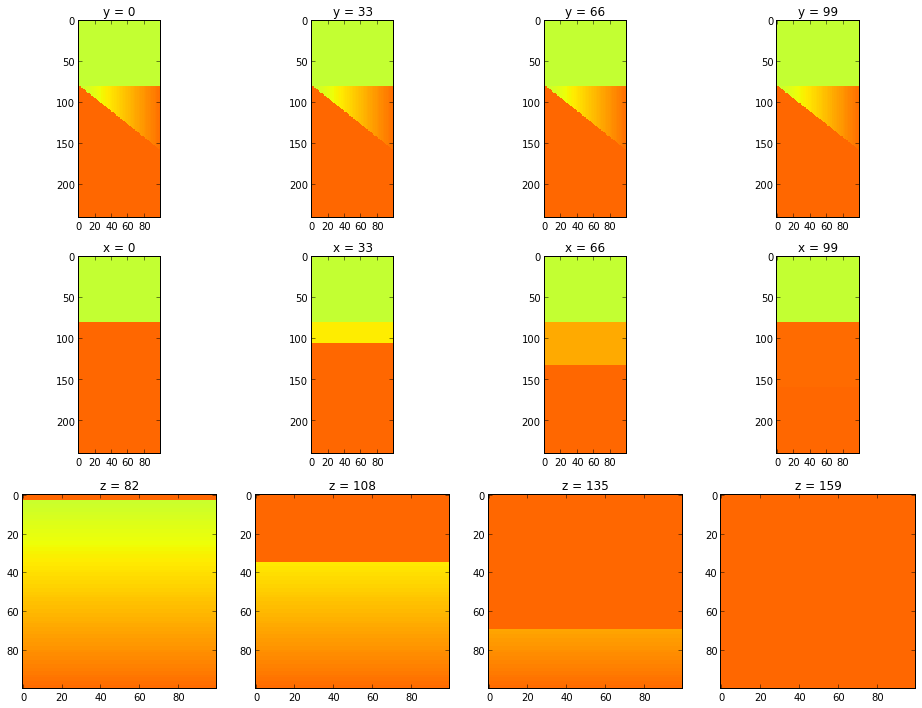

In [10]:
plot_slices(earth, interpolation='nearest', cmap='jet')

## Making a synthetic

Now we can compute reflection coefficients

In [11]:
def make_rc(earth):
    upper = earth[:-1][:][:]
    lower = earth[1:][:][:]
    
    return (lower - upper) / (lower + upper)

rc = make_rc(earth)

And we need a wavelet:

In [12]:
from scipy.signal import ricker

In [13]:
n_samples = depth
n_traces = length
n_xlines = width

def make_synth(rc, f=20):
    points = 128
    synth = np.zeros((n_samples+points-2, n_traces, n_xlines))
    wavelet = ricker(points, 1000/(4.*f))
    wavelet = wavelet / max(wavelet)
    for i in range(int(n_traces)):
        for j in range(int(n_xlines)):
            synth[:,i,j] = np.convolve(rc[:,i,j], wavelet)
    synth = synth[np.ceil(len(wavelet))/2:-np.ceil(len(wavelet))/2,:,:]
    return synth

def forward_model(model=None, rocks=None, earth=None, freq=20):
    """
    Meta function to do everything from scratch
    """
    if model:
        ai = make_ai(rocks)
        earth = assign_rocks(model, ai)    
    rc = make_rc(earth)
    return make_synth(rc,freq)

Generate the 3D synthetic seismic volume.

In [14]:
synthmod = forward_model(earth=earth, freq=20)

And plot, using the same routine as before. 

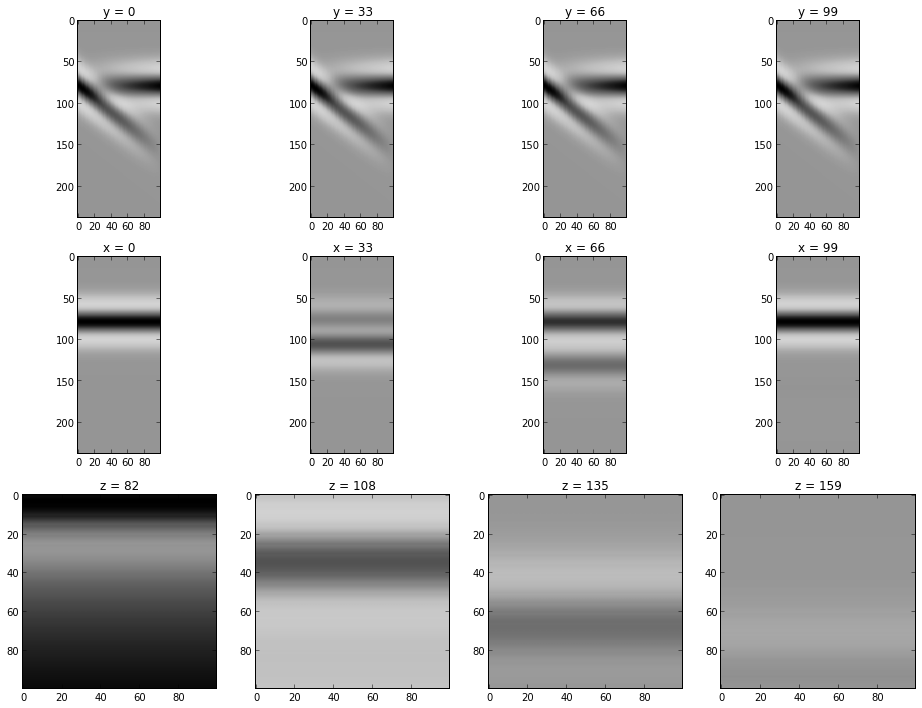

In [15]:
maxrc = np.amax(abs(synthmod))
plot_slices(synthmod, interpolation='bilinear', vmax=maxrc, vmin=-maxrc)

## Making an RGB blend

In [16]:
from scipy.signal import hilbert

In [17]:
def make_triplet(model=None, ai=None, earth=None, freqs=(60,30,15)):
    if model:
        obj = model
    else:
        obj = earth
        
    triplet = np.empty((obj.shape[0]-2, obj.shape[1], obj.shape[2], 3))
    
    for f in freqs:
        if model:
            triplet[:,:,:,freqs.index(f)] = forward_model(model=model, ai=ai, freq=f)
        else:
            triplet[:,:,:,freqs.index(f)] = forward_model(earth=earth, freq=f)
        
    return triplet

def scaled_rgb(triplet):
    envelope = abs(hilbert(triplet))
    for i in range(3):
        envelope[:,:,:,i]= envelope[:,:,:,i]/np.amax(envelope[:,:,:,i])
    return envelope

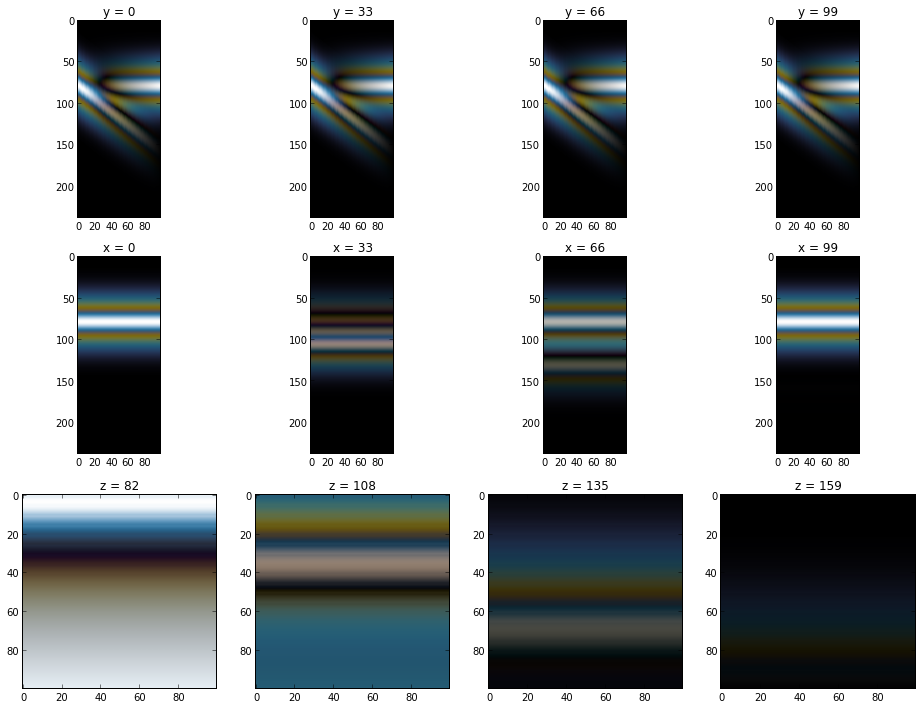

In [18]:
rgb = scaled_rgb(make_triplet(earth=earth, freqs=(25,20,15)))
plot_slices(rgb, interpolation='bilinear')

## Bugs, improvements

See comments on <code>Spectral_wedge.ipynb</code>.